<a href="https://colab.research.google.com/github/Dmitri9149/TensorFlow_PyTorch_CNN/blob/main/PyTorch_LeNet_AvgPooling%2BReLU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Draft Model.
Sigmoid was changed to ReLu between all layers, and model is not working.  
Keeping sigmoid between first 2 layers (conv and pool layers) + ReLU for last 2 layers work fine. 

In [14]:
# -U: Upgrade all packages to the newest available version
!pip install -U d2l

from d2l import torch as d2l
import torch
from torch import nn
import numpy as np
import torch.nn.functional as F

Requirement already up-to-date: d2l in /usr/local/lib/python3.6/dist-packages (0.15.1)


### Convolutional Neural Network LeNet.

This is implementation of classical LeNet convolutional neural network , originally designed for handwritten digit recignition. 

The basic architecture is used for some experimentation: 
we may change AveragePooling to MaxPooling and Sigmoid to ReLu activations. It is interesting to check, how it will change the results.

I use some code from d2l.ai : http://d2l.ai/ 

There is also some intermediate code with experimentation with PyTorch objects.

## In this version we use Average Pooling and Sigmoid activation.

In [15]:
## assume the input image is (n,m) matrixes
class Reshape(torch.nn.Module):
  def __init__(self,rows,cols):
    super().__init__()
    self.rows=torch.tensor(rows)
    self.cols=torch.tensor(cols)
  def forward(self,x):
    return x.view(-1,1,self.rows,self.cols)

reshape = Reshape(rows=28,cols=28)
print(reshape.rows,reshape.cols)

tensor(28) tensor(28)


In [16]:
class LN(nn.Module):

    def __init__(self):
        super(LN, self).__init__()
        self.reshape = Reshape(rows=28,cols=28)
        self.conv1 = nn.Conv2d(1,6,kernel_size=5, padding=2)
        self.sigmoid = nn.Sigmoid()
        self.relu=nn.ReLU()
        self.conv2 = nn.Conv2d(6,16,kernel_size=5)
        self.avgpool1=nn.AvgPool2d(kernel_size=2, stride=2)
        self.maxpool1=nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.avgpool2=nn.AvgPool2d(kernel_size=2, stride=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten=nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(self.reshape(x))
        x = F.avg_pool2d(F.relu(x), kernel_size = (2,2), stride=2)
        x = F.avg_pool2d(F.relu(self.conv2(x)), kernel_size = (2,2), stride=2)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))        
        x = self.fc3(x)
        return x


net = LN()
print(net)

LN(
  (reshape): Reshape()
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (sigmoid): Sigmoid()
  (relu): ReLU()
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [17]:
params = list(net.parameters())
print(len(params))
print(params[0].size()) ### print lernable parameters shape : Conv2d -> first

10
torch.Size([6, 1, 5, 5])


In [18]:
for i in range(len(params)):
  print(params[i].size())

torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


In [19]:
# torch.Size([6, 1, 5, 5])  conv1 OK 
# torch.Size([6]) 1 st pooling layer ?? 
# torch.Size([16, 6, 5, 5]) conv2 OK 
# torch.Size([16]) 2 nd pooling layer  ?? 
# torch.Size([120, 400]) linear OK 
# torch.Size([120]) sigmoid (or relu) ??
# torch.Size([84, 120]) linear OK 
# torch.Size([84]) sigmoid (or relu) 
# torch.Size([10, 84]) linear OK 
# torch.Size([10]) ?? what is the layer ??

#### Training

Data loading

In [20]:
# from d2l.ai book
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
## list of transformations
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [21]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

Evaluate accuracy on GPU (if we have GPU) 

In [22]:
## y_hat is assumed to be a matrix, and we assume that the second 
## dimension stores prediction scores for each class.
## we work in paradigm: first dim -> batch ; second dim -> probabilities 
## of values 

def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
## choose the best value for every sample in batch
        y_hat = y_hat.argmax(dim=1)        
## y_hat is transformed to the same dtype as y and compared with y to produce 
## bool tensor of True / False
## y is label
        y_hat_cast = y_hat.type(y.dtype) ## -> y_hat_cast now have dtype of y
        cmp =  (y_hat_cast == y) ## -> cmp is tensor of False and True, have to convert to float
    else: raise Exception("Input is not a matrix. Exit.")
    return torch.sum(cmp).float()

In [23]:
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = torch.zeros(n)

    def add(self, *args):
        self.data = torch.as_tensor([a + float(b) for a, b in zip(self.data, args)])

    def reset(self):
        self.data = torch.zeros(n)

    def __getitem__(self, idx):
        return self.data[idx]

In [24]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    net.eval()  # Set the model to evaluation mode
    if not device:
        device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [25]:
## from d2l.ai
def train_ch6(net, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = Accumulator(3)
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0]/metric[2]
            train_acc = metric[1]/metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')


loss 2.303, train acc 0.099, test acc 0.100
3459.5 examples/sec on cpu


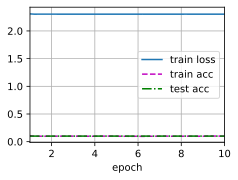

In [26]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr)